In working with a differential equation, our system will evolve through many states. Particular states of the system may be of interest to us, and we say that an ***"event"*** is triggered when our system reaches these states. For example, events may include the moment when our system reaches a particular temperature or velocity. We ***handle*** these events with ***callbacks***, which tell us what to do once an event has been triggered.

These callbacks allow for a lot more than event handling, however. For example, we can use callbacks to achieve high-level behavior like exactly preserve conservation laws and save the trace of a matrix at pre-defined time points. This extra functionality allows us to use the callback system as a modding system for the DiffEq ecosystem's solvers.

This tutorial is an introduction to the callback and event handling system in DifferentialEquations.jl, documented in the [Event Handling and Callback Functions](http://docs.juliadiffeq.org/latest/features/callback_functions.html) page of the documentation. We will also introduce you to some of the most widely used callbacks in the [Callback Library](http://docs.juliadiffeq.org/latest/features/callback_library.html), which is a library of pre-built mods.

## Events and Continuous Callbacks

Event handling is done through continuous callbacks. Callbacks take a function, `condition`, which triggers an `affect!` when `condition == 0`. These callbacks are called "continuous" because they will utilize rootfinding on the interpolation to find the "exact" time point at which the condition takes place and apply the `affect!` at that time point.

***Let's use a bouncing ball as a simple system to explain events and callbacks.*** Let's take Newton's model of a ball falling towards the Earth's surface via a gravitational constant `g`. In this case, the velocity is changing via `-g`, and position is changing via the velocity. Therefore we receive the system of ODEs:
# Callbacks and Events
### Chris Rackauckas

In [1]:
using DifferentialEquations, ParameterizedFunctions
ball! = @ode_def BallBounce begin
  dy =  v
  dv = -g
end g

(::BallBounce{getfield(Main, Symbol("##3#7")),getfield(Main, Symbol("##4#8")),getfield(Main, Symbol("##5#9")),Nothing,Nothing,getfield(Main, Symbol("##6#10")),Expr,Expr}) (generic function with 2 methods)

We want the callback to trigger when `y=0` since that's when the ball will hit the Earth's surface (our event). We do this with the condition:

In [2]:
function condition(u,t,integrator)
  u[1]
end

condition (generic function with 1 method)

Recall that the `condition` will trigger when it evaluates to zero, and here it will evaluate to zero when `u[1] == 0`, which occurs when `v == 0`. *Now we have to say what we want the callback to do.* Callbacks make use of the [Integrator Interface](http://docs.juliadiffeq.org/latest/basics/integrator.html). Instead of giving a full description, a quick and usable rundown is:

- Values are strored in `integrator.u`
- Times are stored in `integrator.t`
- The parameters are stored in `integrator.p`
- `integrator(t)` performs an interpolation in the current interval between `integrator.tprev` and `integrator.t` (and allows extrapolation)
- User-defined options (tolerances, etc.) are stored in `integrator.opts`
- `integrator.sol` is the current solution object. Note that `integrator.sol.prob` is the current problem

While there's a lot more on the integrator interface page, that's a working knowledge of what's there.

What we want to do with our `affect!` is to "make the ball bounce". Mathematically speaking, the ball bounces when the sign of the velocity flips. As an added behavior, let's also use a small friction constant to dampen the ball's velocity. This way only a percentage of the velocity will be retained when the event is triggered and the callback is used.  We'll define this behavior in the `affect!` function:

In [3]:
function affect!(integrator)
    integrator.u[2] = -integrator.p[2] * integrator.u[2]
end

affect! (generic function with 1 method)

`integrator.u[2]` is the second value of our model, which is `v` or velocity, and `integrator.p[2]`, is our friction coefficient.

Therefore `affect!` can be read as follows: `affect!` will take the current value of velocity, and multiply it `-1` multiplied by our friction coefficient. Therefore the ball will change direction and its velocity will dampen when `affect!` is called.

Now let's build the `ContinuousCallback`:

In [4]:
bounce_cb = ContinuousCallback(condition,affect!)

ContinuousCallback{typeof(condition),typeof(affect!),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing}(condition, affect!, affect!, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, Bool[true, true], 2.220446049250313e-15, 0)

Now let's make an `ODEProblem` which has our callback:

In [5]:
u0 = [50.0,0.0]
tspan = (0.0,15.0)
p = (9.8,0.9)
prob = ODEProblem(ball!,u0,tspan,p,callback=bounce_cb)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 15.0)
u0: [50.0, 0.0]

Notice that we chose a friction constant of `0.9`. Now we can solve the problem and plot the solution as we normally would:

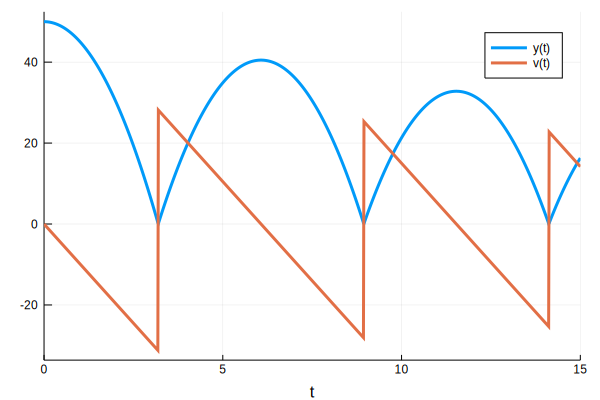

In [6]:
sol = solve(prob,Tsit5())
using Plots; gr()
plot(sol)

and tada, the ball bounces! Notice that the `ContinuousCallback` is using the interpolation to apply the effect "exactly" when `v == 0`. This is crucial for model correctness, and thus when this property is needed a `ContinuousCallback` should be used.

#### Exercise 1

In our example we used a constant coefficient of friction, but if we are bouncing the ball in the same place we may be smoothing the surface (say, squishing the grass), causing there to be less friction after each bounce. In this more advanced model, we want the friction coefficient at the next bounce to be `sqrt(friction)` from the previous bounce (since `friction < 1`, `sqrt(friction) > friction` and `sqrt(friction) < 1`).

Hint: there are many ways to implement this. One way to do it is to make `p` a `Vector` and mutate the friction coefficient in the `affect!`.

## Discrete Callbacks

A discrete callback checks a `condition` after every integration step and, if true, it will apply an `affect!`. For example, let's say that at time `t=2` we want to include that a kid kicked the ball, adding `20` to the current velocity. This kind of situation, where we want to add a specific behavior which does not require rootfinding, is a good candidate for a `DiscreteCallback`. In this case, the `condition` is a boolean for whether to apply the `affect!`, so:

In [7]:
function condition_kick(u,t,integrator)
    t == 2
end

condition_kick (generic function with 1 method)

We want the kick to occur at `t=2`, so we check for that time point. When we are at this time point, we want to do:

In [8]:
function affect_kick!(integrator)
    integrator.u[2] += 50
end

affect_kick! (generic function with 1 method)

Now we build the problem as before:

In [9]:
kick_cb = DiscreteCallback(condition_kick,affect_kick!)
u0 = [50.0,0.0]
tspan = (0.0,10.0)
p = (9.8,0.9)
prob = ODEProblem(ball!,u0,tspan,p,callback=kick_cb)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [50.0, 0.0]

Note that, since we are requiring our effect at exactly the time `t=2`, we need to tell the integration scheme to step at exactly `t=2` to apply this callback. This is done via the option `tstops`, which is like `saveat` but means "stop at these values".

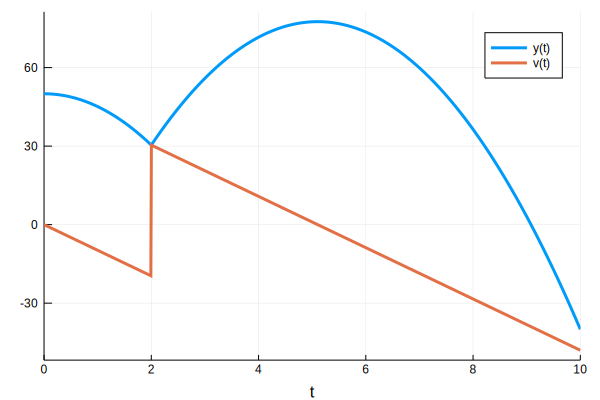

In [10]:
sol = solve(prob,Tsit5(),tstops=[2.0])
plot(sol)

Note that this example could've been done with a `ContinuousCallback` by checking the condition `t-2`.

## Merging Callbacks with Callback Sets

In some cases you may want to merge callbacks to build up more complex behavior. In our previous result, notice that the model is unphysical because the ball goes below zero! What we really need to do is add the bounce callback together with the kick. This can be achieved through the `CallbackSet`.

In [11]:
cb = CallbackSet(bounce_cb,kick_cb)

CallbackSet{Tuple{ContinuousCallback{typeof(condition),typeof(affect!),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing}},Tuple{DiscreteCallback{typeof(condition_kick),typeof(affect_kick!),typeof(DiffEqBase.INITIALIZE_DEFAULT)}}}((ContinuousCallback{typeof(condition),typeof(affect!),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing}(condition, affect!, affect!, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, Bool[true, true], 2.220446049250313e-15, 0),), (DiscreteCallback{typeof(condition_kick),typeof(affect_kick!),typeof(DiffEqBase.INITIALIZE_DEFAULT)}(condition_kick, affect_kick!, DiffEqBase.INITIALIZE_DEFAULT, Bool[true, true]),))

A `CallbackSet` merges their behavior together. The logic is as follows. In a given interval, if there are multiple continuous callbacks that would trigger, only the one that triggers at the earliest time is used. The time is pulled back to where that continuous callback is triggered, and then the `DiscreteCallback`s in the callback set are called in order.

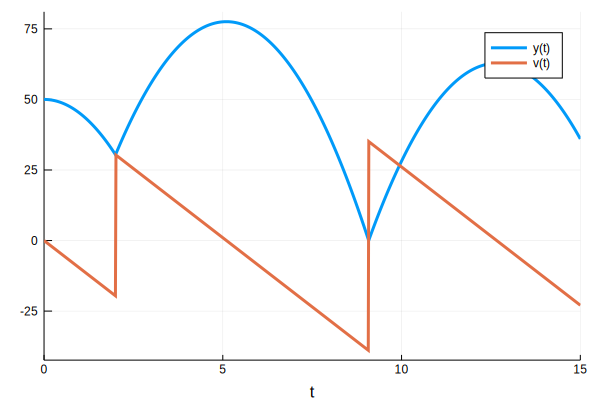

In [12]:
u0 = [50.0,0.0]
tspan = (0.0,15.0)
p = (9.8,0.9)
prob = ODEProblem(ball!,u0,tspan,p,callback=cb)
sol = solve(prob,Tsit5(),tstops=[2.0])
plot(sol)

Notice that we have now merged the behaviors. We can then nest this as deep as we like.

#### Exercise 2

Add to the model a linear wind with resistance that changes the acceleration to `-g + k*v` after `t=10`. Do so by adding another parameter and allowing it to be zero until a specific time point where a third callback triggers the change.

## Integration Termination and Directional Handling

Let's look at another model now: the model of the [Harmonic Oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator). We can write this as:

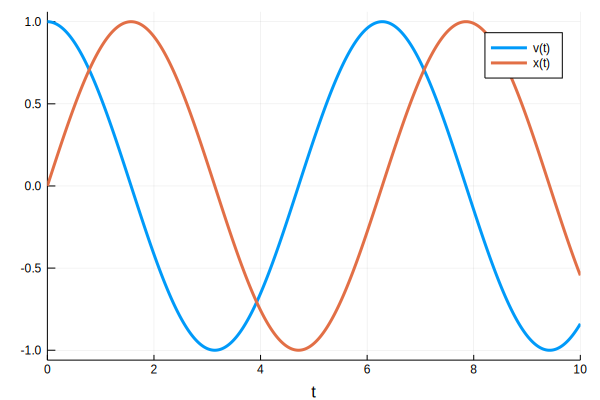

In [13]:
u0 = [1.,0.]
harmonic! = @ode_def HarmonicOscillator begin
   dv = -x
   dx = v
end
tspan = (0.0,10.0)
prob = ODEProblem(harmonic!,u0,tspan)
sol = solve(prob)
plot(sol)

Let's instead stop the integration when a condition is met. From the [Integrator Interface stepping controls](http://docs.juliadiffeq.org/latest/basics/integrator.html#Stepping-Controls-1) we see that `terminate!(integrator)` will cause the integration to end. So our new `affect!` is simply:

In [14]:
function terminate_affect!(integrator)
    terminate!(integrator)
end

terminate_affect! (generic function with 1 method)

Let's first stop the integration when the particle moves back to `x=0`. This means we want to use the condition:

In [15]:
function terminate_condition(u,t,integrator)
    u[2]
end
terminate_cb = ContinuousCallback(terminate_condition,terminate_affect!)

ContinuousCallback{typeof(terminate_condition),typeof(terminate_affect!),typeof(terminate_affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing}(terminate_condition, terminate_affect!, terminate_affect!, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, Bool[true, true], 2.220446049250313e-15, 0)

Note that instead of adding callbacks to the problem, we can also add them to the `solve` command. This will automatically form a `CallbackSet` with any problem-related callbacks and naturally allows you to distinguish between model features and integration controls.

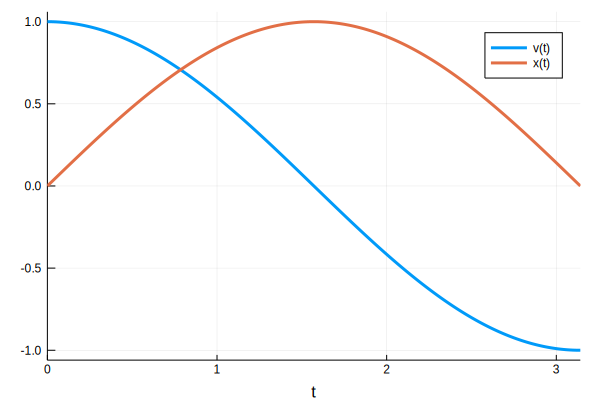

In [16]:
sol = solve(prob,callback=terminate_cb)
plot(sol)

Notice that the harmonic oscilator's true solution here is `sin` and `cosine`, and thus we would expect this return to zero to happen at `t=π`:

In [17]:
sol.t[end]

3.1415902498226123

This is one way to approximate π! Lower tolerances and arbitrary precision numbers can make this more exact, but let's not look at that. Instead, what if we wanted to halt the integration after exactly one cycle? To do so we would need to ignore the first zero-crossing. Luckily in these types of scenarios there's usually a structure to the problem that can be exploited. Here, we only want to trigger the `affect!` when crossing from positive to negative, and not when crossing from negative to positive. In other words, we want our `affect!` to only occur on upcrossings.

If the `ContinuousCallback` constructor is given a single `affect!`, it will occur on both upcrossings and downcrossings. If there are two `affect!`s given, then the first is for upcrossings and the second is for downcrossings. An `affect!` can be ignored by using `nothing`. Together, the "upcrossing-only" version of the effect means that the first `affect!` is what we defined above and the second is `nothing`. Therefore we want:

In [18]:
terminate_upcrossing_cb = ContinuousCallback(terminate_condition,terminate_affect!,nothing)

ContinuousCallback{typeof(terminate_condition),typeof(terminate_affect!),Nothing,typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing}(terminate_condition, terminate_affect!, nothing, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, Bool[true, true], 2.220446049250313e-15, 0)

Which gives us:

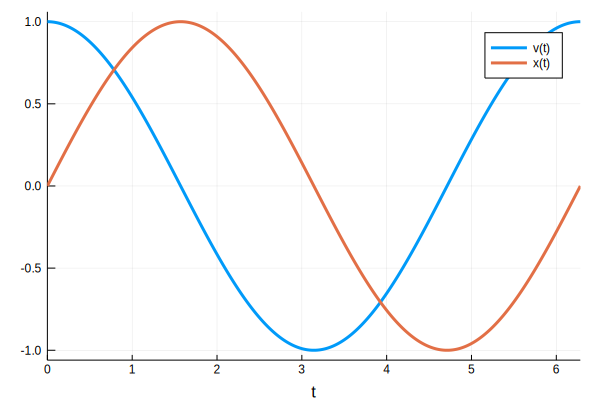

In [19]:
sol = solve(prob,callback=terminate_upcrossing_cb)
plot(sol)

## Callback Library

As you can see, callbacks can be very useful and through `CallbackSets` we can merge together various behaviors. Because of this utility, there is a library of pre-built callbacks known as the [Callback Library](http://docs.juliadiffeq.org/latest/features/callback_library.html). We will walk through a few examples where these callbacks can come in handy.

### Manifold Projection

One callback is the manifold projection callback. Essentially, you can define any manifold `g(sol)=0` which the solution must live on, and cause the integration to project to that manifold after every step. As an example, let's see what happens if we naively run the harmonic oscillator for a long time:

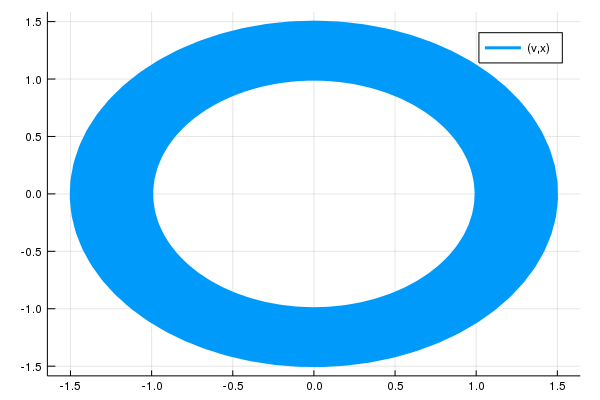

In [20]:
tspan = (0.0,10000.0)
prob = ODEProblem(harmonic!,u0,tspan)
sol = solve(prob)
gr(fmt=:png) # Make it a PNG instead of an SVG since there's a lot of points!
plot(sol,vars=(1,2))

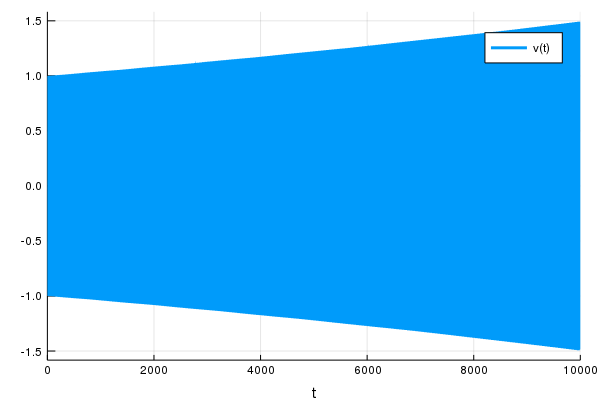

In [21]:
plot(sol,vars=(0,1),denseplot=false)

Notice that what's going on is that the numerical solution is drifting from the true solution over this long time scale. This is because the integrator is not conserving energy.

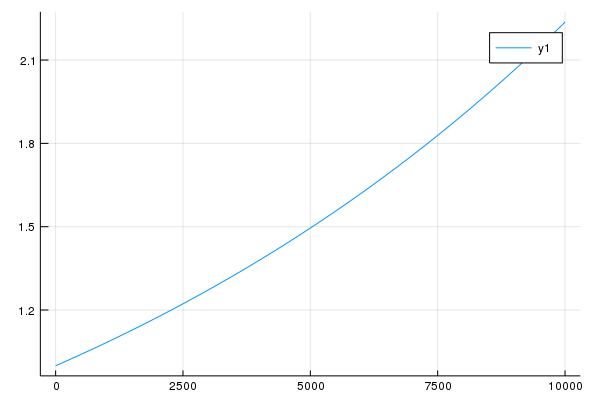

In [22]:
plot(sol.t,[u[2]^2 + u[1]^2 for u in sol.u]) # Energy ~ x^2 + v^2

Some integration techniques like [symplectic integrators](http://docs.juliadiffeq.org/latest/solvers/dynamical_solve.html#Symplectic-Integrators-1) are designed to mitigate this issue, but instead let's tackle the problem by enforcing conservation of energy. To do so, we define our manifold as the one where energy equals 1 (since that holds in the initial condition), that is:

In [23]:
function g(resid,u,p,t)
  resid[1] = u[2]^2 + u[1]^2 - 1
  resid[2] = 0
end

g (generic function with 1 method)

Here the residual measures how far from our desired energy we are, and the number of conditions matches the size of our system (we ignored the second one by making the residual 0). Thus we define a `ManifoldProjection` callback and add that to the solver:

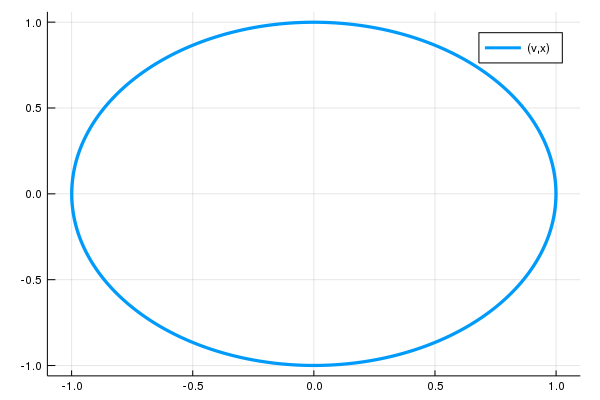

In [24]:
cb = ManifoldProjection(g)
sol = solve(prob,callback=cb)
plot(sol,vars=(1,2))

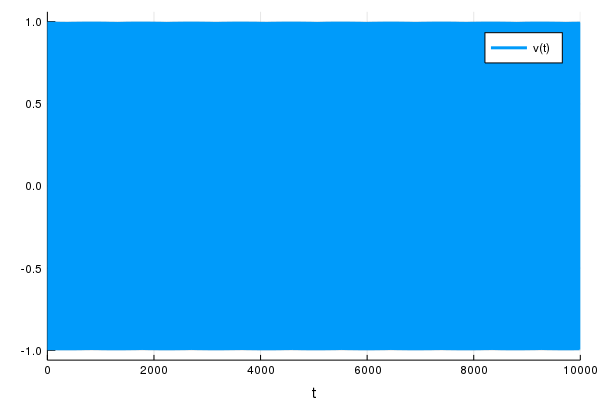

In [25]:
plot(sol,vars=(0,1),denseplot=false)

Now we have "perfect" energy conservation, where if it's ever violated too much the solution will get projected back to `energy=1`.

In [26]:
u1,u2 = sol[500]
u2^2 + u1^2

1.0000425845647514

While choosing different integration schemes and using lower tolerances can achieve this effect as well, this can be a nice way to enforce physical constraints and is thus used in many disciplines like molecular dynamics. Another such domain constraining callback is the [`PositiveCallback()`](http://docs.juliadiffeq.org/latest/features/callback_library.html#PositiveDomain-1) which can be used to enforce positivity of the variables.

### SavingCallback

The `SavingCallback` can be used to allow for special saving behavior. Let's take a linear ODE define on a system of 1000x1000 matrices:

In [27]:
prob = ODEProblem((du,u,p,t)->du.=u,rand(1000,1000),(0.0,1.0))

ODEProblem with uType Array{Float64,2} and tType Float64. In-place: true
timespan: (0.0, 1.0)
u0: [0.256245 0.177517 … 0.395667 0.369452; 0.612908 0.835301 … 0.587398 0.79605; … ; 0.97818 0.63705 … 0.372874 0.219243; 0.461441 0.59452 … 0.948979 0.284096]

In fields like quantum mechanics you may only want to know specific properties of the solution such as the trace or the norm of the matrix. Saving all of the 1000x1000 matrices can be a costly way to get this information! Instead, we can use the `SavingCallback` to save the `trace` and `norm` at specified times. To do so, we first define our `SavedValues` cache. Our time is in terms of `Float64`, and we want to save tuples of `Float64`s (one for the `trace` and one for the `norm`), and thus we generate the cache as:

In [28]:
saved_values = SavedValues(Float64, Tuple{Float64,Float64})

SavedValues{tType=Float64, savevalType=Tuple{Float64,Float64}}
t:
Float64[]
saveval:
Tuple{Float64,Float64}[]

Now we define the `SavingCallback` by giving it a function of `(u,p,t,integrator)` that returns the values to save, and the cache:

In [29]:
using LinearAlgebra
cb = SavingCallback((u,t,integrator)->(tr(u),norm(u)), saved_values)

DiscreteCallback{getfield(DiffEqCallbacks, Symbol("##28#29")),DiffEqCallbacks.SavingAffect{getfield(Main, Symbol("##23#24")),Float64,Tuple{Float64,Float64},DataStructures.BinaryHeap{Float64,DataStructures.LessThan},Array{Float64,1}},typeof(DiffEqCallbacks.saving_initialize)}(getfield(DiffEqCallbacks, Symbol("##28#29"))(), DiffEqCallbacks.SavingAffect{getfield(Main, Symbol("##23#24")),Float64,Tuple{Float64,Float64},DataStructures.BinaryHeap{Float64,DataStructures.LessThan},Array{Float64,1}}(getfield(Main, Symbol("##23#24"))(), SavedValues{tType=Float64, savevalType=Tuple{Float64,Float64}}
t:
Float64[]
saveval:
Tuple{Float64,Float64}[], DataStructures.BinaryHeap{Float64,DataStructures.LessThan}(DataStructures.LessThan(), Float64[]), Float64[], true, true, 0), DiffEqCallbacks.saving_initialize, Bool[false, false])

Here we take `u` and save `(tr(u),norm(u))`. When we solve with this callback:

In [30]:
sol = solve(prob, Tsit5(), callback=cb, save_everystep=false, save_start=false, save_end = false) # Turn off normal saving

retcode: Success
Interpolation: 1st order linear
t: 0-element Array{Float64,1}
u: 0-element Array{Array{Float64,2},1}

Our values are stored in our `saved_values` variable:

In [31]:
saved_values.t

5-element Array{Float64,1}:
 0.0               
 0.1001289525934326
 0.3483900224222022
 0.6837355074875192
 1.0               

In [32]:
saved_values.saveval

5-element Array{Tuple{Float64,Float64},1}:
 (506.28437955935397, 577.3665745967578) 
 (559.6029301733918, 638.1710358311421)  
 (717.295971866344, 818.004139509448)    
 (1003.0834711035444, 1143.9161292112985)
 (1376.223568503298, 1569.4449991083018) 

By default this happened only at the solver's steps. But the `SavingCallback` has similar controls as the integrator. For example, if we want to save at every `0.1` seconds, we do can so using `saveat`:

In [33]:
saved_values = SavedValues(Float64, Tuple{Float64,Float64}) # New cache
cb = SavingCallback((u,t,integrator)->(tr(u),norm(u)), saved_values, saveat = 0.0:0.1:1.0)
sol = solve(prob, Tsit5(), callback=cb, save_everystep=false, save_start=false, save_end = false) # Turn off normal saving

retcode: Success
Interpolation: 1st order linear
t: 0-element Array{Float64,1}
u: 0-element Array{Array{Float64,2},1}

In [34]:
saved_values.t

11-element Array{Float64,1}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

In [35]:
saved_values.saveval

11-element Array{Tuple{Float64,Float64},1}:
 (506.28437955935397, 577.3665745967578) 
 (559.5307725767756, 638.0887473267537)  
 (618.3771597034325, 705.1971518805032)  
 (683.4123877365661, 779.3633089922234)  
 (755.2876787332425, 861.3298721261978)  
 (834.7217826639279, 951.9165035615563)  
 (922.5099281138822, 1052.03008176983)   
 (1019.5315397298738, 1162.6735023891588)
 (1126.7566978432976, 1284.9530447768268)
 (1245.2582348703568, 1420.0921667408784)
 (1376.223568503298, 1569.4449991083018) 

#### Exercise 3

Go back to the Harmonic oscillator. Use the `SavingCallback` to save an array for the energy over time, and do this both with and without the `ManifoldProjection`. Plot the results to see the difference the projection makes.